In [14]:
import numpy as np

from poisson_2d import CosCosData
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve

from fealpy.mesh.triangle_mesh import TriangleMesh 
from fealpy.functionspace.lagrange_fe_space import LagrangeFESpace
from fealpy.fem.diffusion_integrator import DiffusionIntegrator 
from fealpy.fem.scalar_source_integrator import ScalarSourceIntegrator
from fealpy.fem.bilinear_form import BilinearForm
from fealpy.fem.linear_form import LinearForm


p = 1
maxit = 5

# Initialize the problem with given true solution
pde = CosCosData()
domain = pde.domain()

# Create the initial triangle mesh
mesh = TriangleMesh.from_box(box = domain, nx = 5, ny = 5)

errorType = ['$|| u - u_h ||_{L2}$']
errorMatrix = np.zeros((1, maxit), dtype=np.float64)

NDof = np.zeros(maxit, dtype=np.int_)
# Main loop for mesh refinement and solution
for i in range(maxit):
    print("The {}-th computation:".format(i))
    # Create Lagrange finite element space
    space = LagrangeFESpace(mesh, p = p, spacetype = 'C', doforder = 'vdims')
    uh = space.function(dim=1)
    print("uh:", uh.shape)
    NDof[i] = space.number_of_global_dofs()

    # Assemble the stiffness matrix
    bform = BilinearForm(space)
    bform.add_domain_integrator(DiffusionIntegrator(q = p+2))
    K = bform.assembly()

    # Assemble the load vector
    lform = LinearForm(space)
    lform.add_domain_integrator(ScalarSourceIntegrator(f = pde.source, q = p+2))
    F = lform.assembly()

    # Apply Pure Dirichlet boundary conditions
    ipoints = space.interpolation_points()
    dflag = space.is_boundary_dof()
    uh.flat[dflag] = pde.dirichlet(ipoints[dflag])
    
    F -= K@uh.flat
    F[dflag.flat] = uh.ravel()[dflag.flat]

    bdIdx = np.zeros(K.shape[0], dtype=np.int_)
    bdIdx[dflag.flat] = 1
    D0 = spdiags(1-bdIdx, 0, K.shape[0], K.shape[0])
    D1 = spdiags(bdIdx, 0, K.shape[0], K.shape[0])
    K = D0@K@D0 + D1

    # Solve the linear system
    uh.flat[:] = spsolve(K, F)

    u_exact = space.interpolate(pde.solution)

    # Compute the errors
    errorMatrix[0, i] = mesh.error(pde.solution, uh)

    # Refine the mesh for the next iteration
    if i < maxit-1:
        mesh.uniform_refine()

# Print error with its type
for i, errType in enumerate(errorType):
    print(errType)
    print(errorMatrix[i])
    print('------')

# Compute error convergence rates
ratios = errorMatrix[:, 0:-1] / errorMatrix[:, 1:]
convergence_rates = np.log2(ratios)
print("convergence_rates:", convergence_rates)

The 0-th computation:
uh: (36, 1)
The 1-th computation:
uh: (121, 1)
The 2-th computation:
uh: (441, 1)
The 3-th computation:
uh: (1681, 1)
The 4-th computation:
uh: (6561, 1)
$|| u - u_h ||_{L2}$
[0.04767787 0.01254474 0.00317891 0.00079747 0.00019954]
------
convergence_rates: [[1.92623726 1.98047798 1.99502491 1.99874878]]


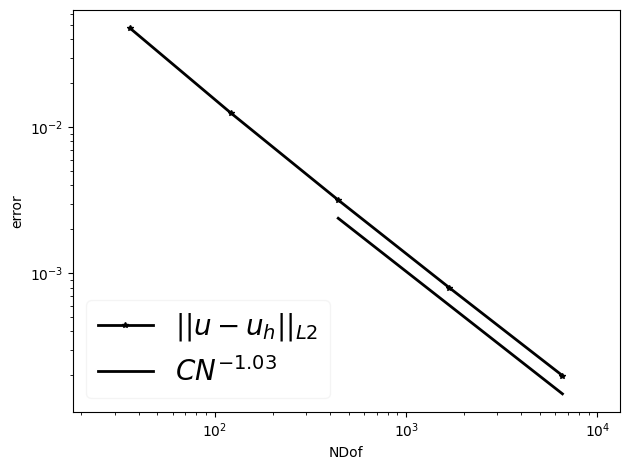

In [15]:
from fealpy.tools.show import showmultirate
import matplotlib.pyplot as plt

showmultirate(plt, 2, NDof, errorMatrix, errorType, propsize=20, lw=2, ms=4)
plt.xlabel('NDof')
plt.ylabel('error')
plt.tight_layout()
plt.show()

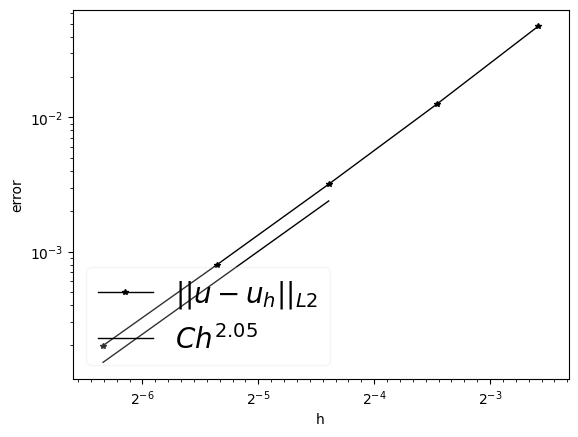

In [16]:
h = 1 / (np.power(NDof, 1/2))     
showmultirate(plt, 2, h, errorMatrix,  errorType, propsize=20)
plt.xlabel('h')
plt.ylabel('error')
plt.show()